In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

11


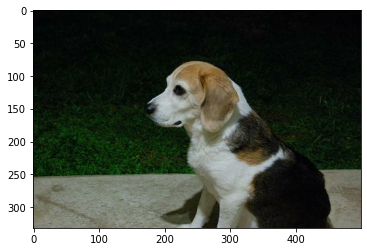

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [4]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/Going_Deeper/3.class activation map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

# CAM

In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

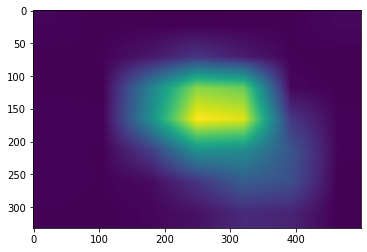

In [6]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [7]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

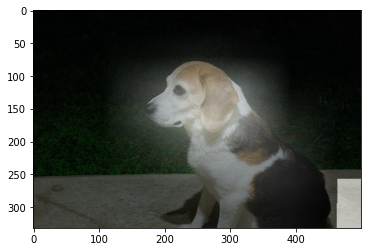

In [8]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# Grad-CAM

In [9]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    #Grad-CAM에서도 CAM과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의한다.
    #but Grad-CAM은 원하는 레이어가 다를 수 있으므로 해당 레이어의 이름으로 찾은 후 output으로 추가한다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    #Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[: , class_idx] #원하는 클래스의 예측값 얻기
        output = conv_output[0] # 원하는 layer의 output을 얻는다
        grad_val = tape.gradient(loss, conv_output)[0]  #예측값에 따른 layer의 gradient를 얻는다.
        
    weights = np.mean(grad_val, axis = (0, 1))
    grad_cam_image = np.zeros(dtype = np.float32, shape = conv_output.shape[0:2])
    for k, w in enumerate(weights):
        #각 클래스별 weight와 해장 layer의 output을 곱해 class activation map을 얻는다.
        grad_cam_image += w*output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

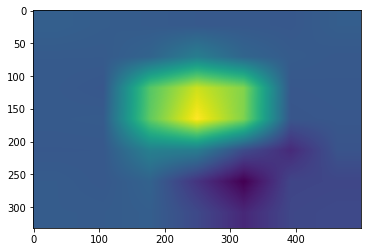

In [11]:
grad_cam_image_1 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image_1)
plt.show()

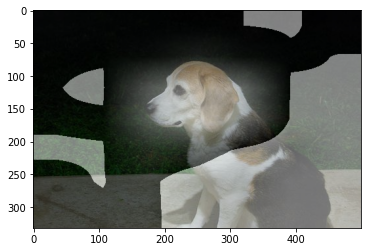

In [12]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_1_3channel = np.stack([grad_cam_image_1*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_1_3channel, origin_image)
plt.imshow(blended_image)

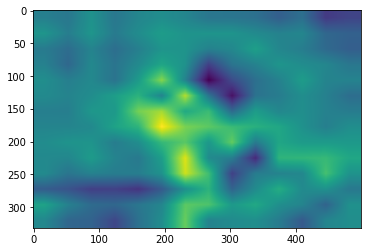

In [13]:
grad_cam_image_2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image_2)
plt.show()

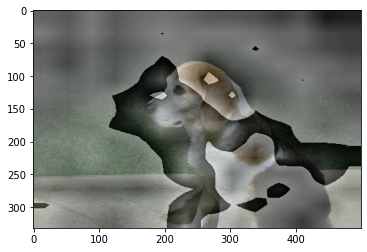

In [14]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_2_3channel = np.stack([grad_cam_image_2*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_2_3channel, origin_image)
plt.imshow(blended_image)

# bbox

#### CAM

In [15]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [16]:
cam_rect = get_bbox(cam_image)
cam_rect

array([[114, 330],
       [114,  40],
       [450,  40],
       [450, 330]])

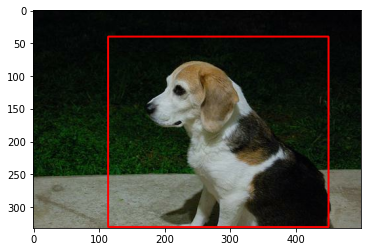

In [18]:
cam_image = copy.deepcopy(item['image'])
cam_image = cv2.drawContours(cam_image, [cam_rect], 0, (255,0,0), 2)
plt.imshow(cam_image)
plt.show()

In [20]:
grad_cam_rect = get_bbox(grad_cam_image_1)
grad_cam_rect

array([[ 78,  89],
       [346,  -6],
       [411, 174],
       [143, 271]])

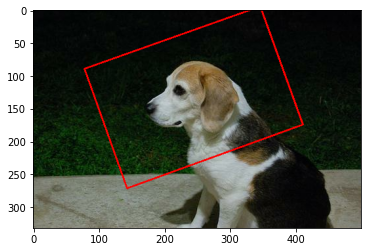

In [22]:
grad_cam_image = copy.deepcopy(item['image'])
grad_cam_image = cv2.drawContours(grad_cam_image, [grad_cam_rect], 0, (255,0,0), 2)
plt.imshow(grad_cam_image)
plt.show()

# IoU

#### CAM

In [23]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [24]:
pred_bbox = rect_to_minmax(cam_rect, item['image'])

In [25]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [26]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7356754708101912

#### Grad-CAM

In [27]:
pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])

In [28]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.41190452404009725